# Notebook for training TopoNEt model on EEG data for face recognition

Model architecture - https://arxiv.org/pdf/1611.08024

Training data - EEG data recorded while people were performing face recognition task.

In [42]:
import copy
import random
import os
from math import trunc

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
import torchmetrics
from pymatreader import read_mat
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import tensorly
from tensorly.decomposition import robust_pca
import mne
from IPython.display import clear_output
from sklearn import metrics

tensorly.set_backend('pytorch')
mne.set_log_level('CRITICAL')

### Model classes

Here we implement EEGNet, but with some modifications, due to the nature of our data and need to use topographical constraints.

In [2]:
class ConstrainedConv2d(nn.Conv2d):
    """
    Implementation of maximum norm constraint for Conv2D layer
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.conv2d(x, self.weight.clamp(max=1.0), self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

class ConstrainedLinear(nn.Linear):
    """
    Implementation of maximum norm constraint for Linear layer
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.linear(x, self.weight.clamp(max=0.5), self.bias)

class EEGNet(nn.Module):
    def __init__(self, sensors: int, samples: int, num_classes: int, filter_size=64, f1=8, depth=2, f2=16, dropout=0.25):
        super().__init__()
        self.block1 = nn.Sequential(
            # This layer does 1d convolutions on data from sensors.
            # Since we have only 500ms of data we set kernel length at 250 (we look at 250ms at once).
            # We can capture patterns with frequency above 4Hz (because data sampling is 1000Hz, 1000 / 250 = 4).
            nn.Conv2d(in_channels=1, out_channels=f1, kernel_size=(1, filter_size), padding='same',
                      bias=False),
            nn.BatchNorm2d(f1),

            # Depthwise convolution. Looks for spatial patterns and combines all data from sensors together.
            # We use our own implementation of convolution layer because pytorch doesn't have weight constraints implemented.
            ConstrainedConv2d(in_channels=f1, out_channels=f1*depth, kernel_size=(sensors, 1), padding='valid',
                              groups=f1, bias=False),
            nn.BatchNorm2d(f1*depth),
            nn.ELU(),

            # Average pooling to reduce sampling rate
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(dropout),
        )
        self.block2 = nn.Sequential(
            # Implementation of Separable convolution.
            # First we use Depthwise convolution (separately for all channels).
            nn.Conv2d(in_channels=f1*depth, out_channels=f1*depth, kernel_size=(1, 16), padding='same',
                      groups=f1*depth, bias=False),

            # Next we combine channels with Pointwise convolution.
            nn.Conv2d(in_channels=f1*depth, out_channels=f2, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(f2),
            nn.ELU(),

            # Average pooling to reduce sampling rate
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(dropout),
            nn.Flatten(),
        )
        # We have to add one dense layer in order to implement topographical constraints.
        # We use our own implementation again to introduce weights constraint.
        self.linear = ConstrainedLinear(in_features=f2*(samples//32), out_features=36)

        # Classifier layer
        self.classifier = nn.Linear(in_features=36, out_features=num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        x = self.block2(x)
        x = self.linear(x)
        return self.classifier(x)


### Spatial loss implementation
Imagines, that neurons on the layer have a spatial organization and calculates average distance between neighbouring weights associated with those neurons.

Inspired by brain neuronal organization.

In [3]:
def spatial_loss(weights: torch.Tensor, grid_width: int):
    """
    Calculates the spatial loss for a set of weights.
    :param weights: weights tensor.
    :param grid_width: width of our imagined grid. Works with any grid of rectangular shape.
    """
    # This is a transformation which helps to calculate indexes of "neighbouring" neurons.
    neighbour_transformations = np.array([-grid_width - 1, -grid_width, -grid_width + 1, -1, +1, grid_width - 1, grid_width, grid_width + 1])

    sp_loss = 0.0
    num_neighbours = 0
    for i in range(weights.shape[0]):
        # We calculate indexes and filter those out of scope.
        neighbours = neighbour_transformations + i
        neighbour_filter = (neighbours >= 0) & (neighbours < weights.shape[0]) & ~ ((i % grid_width == grid_width - 1) & (neighbours % grid_width == 0)) & ~ ((i % grid_width == 0) & (neighbours % grid_width == grid_width - 1))
        neighbours = neighbours[neighbour_filter]

        # We calculate squared distance between weights of the neuron and its neighbours.
        for neighbour in neighbours:
            distance = torch.norm(weights[i] - weights[neighbour])
            sp_loss += distance

        num_neighbours += len(neighbours)

    # We return an average distance.
    return sp_loss / num_neighbours

### Train and Test steps

In [4]:
def train_step(model, train_data, loss_fn, optimizer, lambda_regularization=0.0, spatial=False, spatial_grid_width=6):
    """
    Performs one training step.
    :param model:
    :param train_data:
    :param loss_fn:
    :param optimizer:
    :param lambda_regularization: regularization parameter for spatial loss.
    :param spatial: True, if we need to calculate spatial loss.
    :param spatial_grid_width: width of grid for spatial loss.
    :return: Average loss during the training cycle.
    """
    model.train()

    y_preds = torch.empty(0, device=DEVICE)
    y_targets = torch.empty(0, device=DEVICE)
    avg_loss = 0.0
    for X, y in train_data:
        X, y = X.to(DEVICE), y.to(DEVICE)
        X = X.unsqueeze(1)
        # Forward pass
        y_logits = model(X)
        # Performance loss
        loss = loss_fn(y_logits, y)
        # Addition of spatial loss
        if spatial:
            loss += lambda_regularization * spatial_loss(model.linear.weight, spatial_grid_width)
        # Zero gradients
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Parameters update
        optimizer.step()

        # Making predictions
        yp = torch.argmax(y_logits, dim=1)
        # Save the loss
        avg_loss += loss
        # Saving predictions
        y_preds = torch.cat((y_preds, yp), dim=0)
        # Saving targets
        y_targets = torch.cat((y_targets, y), dim=0)

    return y_preds, y_targets, avg_loss / len(train_data)

def test_step(model, test_data, loss_fn, lambda_regularization=0.0, spatial=False, spatial_grid_width=6):
    """
    Performs one test step.
    :param model:
    :param test_data:
    :param loss_fn:
    :param lambda_regularization: regularization parameter for spatial loss.
    :param spatial: True, if we need to calculate spatial loss.
    :param spatial_grid_width: width of grid for spatial loss.
    :return: model predictions on test data, targets and average loss during the test cycle.
    """
    model.eval()

    y_preds = torch.empty(0, device=DEVICE)
    y_targets = torch.empty(0, device=DEVICE)
    avg_loss = 0.0
    with torch.inference_mode():
        for X, y in test_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            X = X.unsqueeze(1)
            # Forward pass
            y_logits = model(X)
            # Performance loss
            loss = loss_fn(y_logits, y)
            # Addition of spatial loss
            if spatial:
                loss += lambda_regularization * spatial_loss(model.linear.weight, spatial_grid_width)
            # Making predictions
            yp = torch.argmax(y_logits, dim=1)
            # Saving predictions
            y_preds = torch.cat((y_preds, yp), dim=0)
            # Saving targets
            y_targets = torch.cat((y_targets, y), dim=0)

            avg_loss += loss

    return y_preds, y_targets, avg_loss / len(test_data)


### Useful functions

In [5]:
def accuracy_plot(train_acc, valid_acc):
    """
    Function to plot the change of accuracy during training.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='red', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validation accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def loss_plot(train_loss, valid_loss):
    """
    Function to plot the change of loss during training.
    """
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='red', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='blue', linestyle='-',
        label='validation loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

### Training loop

In [6]:
def train_model(model, train_loader, test_loader, epochs, loss_fn, optimizer,
                spatial=False, lambda_regularization=0.0, spatial_grid_width=6, disable_logs=False):

    # Since dataset is more or less balanced, we will use accuracy metric
    accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(DEVICE)
    best_acc = 0
    best_checkpoint = {}
    loss_history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': [],
    }
    for epoch in tqdm(range(epochs), disable=disable_logs):

        predictions, targets, train_loss = train_step(model, train_loader, loss_fn, optimizer, lambda_regularization=lambda_regularization,
                                spatial=spatial, spatial_grid_width=spatial_grid_width)

        train_acc = accuracy(predictions, targets)

        predictions, targets, test_loss = test_step(model, test_loader, loss_fn, lambda_regularization=lambda_regularization,
                                                    spatial=spatial, spatial_grid_width=spatial_grid_width)
        test_acc = accuracy(predictions, targets)

        if not disable_logs:
            print(f'After epoch {epoch}, avg training loss is {train_loss:.4f}, avg validation loss is {test_loss:.4f}, acc on train set is {train_acc * 100:.2f}% and acc on validation set is {test_acc * 100:.2f}%')

        loss_history['train_loss'].append(train_loss.item())
        loss_history['valid_loss'].append(test_loss.item())
        loss_history['train_acc'].append(train_acc.item())
        loss_history['valid_acc'].append(test_acc.item())

        # Saving model with the lowest test loss
        if test_acc > best_acc:
            best_acc = test_acc
            best_checkpoint = {
                'epoch': epoch,
                'state_dict': copy.deepcopy(model.state_dict()),
                'accuracy': test_acc,
                'loss': test_loss,
            }

    return best_checkpoint, loss_history

### Cross-validation loop

In [43]:
def train_with_cross_validation(model_class, model_params: dict, data, epochs, random_seed=42, disable_logs=False):
    """
    Function to train several models using 10-fold cross validation.
    :param model_class: class of model we want to train.
    :param model_params: parameters for models. ['model'] - parameters of model, ['spatial'] - parameters for spatial component.
    :param data:
    :param epochs:
    :param random_seed:
    :param disable_logs:
    :return: trained models with additional information.
    """
    accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(DEVICE)

    # Prepare data
    test_size = int(0.1 * len(data))
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    dataset, test_dataset = random_split(data, [len(data) - test_size, test_size])
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

    resulting_models = []
    # Prepare folds
    kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
    for i, (train_idx, val_idx) in tqdm(enumerate(kfold.split(dataset)), total=10):
        if not disable_logs:
            print(f'Training on fold {i}')
        # Prepare data loaders
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)
        validation_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        # Train one model. We get the best checkpoint
        model = model_class(**model_params['model']).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        loss_fn = torch.nn.CrossEntropyLoss()
        best_checkpoint, loss_history = train_model(model, train_loader, validation_loader, epochs, loss_fn, optimizer, disable_logs=disable_logs, **model_params['spatial'])

        # Load the best checkpoint
        model = model_class(**model_params['model']).to(DEVICE)
        model.load_state_dict(best_checkpoint['state_dict'])
        model.eval()

        # Test the best checkpoint and save results
        predictions, targets, test_loss = test_step(model, test_loader, loss_fn, **model_params['spatial'])
        test_acc = accuracy(predictions, targets)
        resulting_models.append({
            'model': copy.deepcopy(model.state_dict()),
            'test_accuracy': test_acc.item(),
            'test_loss': test_loss,
            'epoch': best_checkpoint['epoch'],
            'loss_history': loss_history,
            'test_predictions': predictions,
            'test_targets': targets,
        })

    return resulting_models


### Cross-validation for all participants

In [8]:
def train_with_cross_validation_all_participants(model_class, model_params: dict, data, epochs, random_seed=42, disable_logs=False):
    """
    Function to train several models using 10-fold cross validation.
    :param model_class: class of model we want to train.
    :param model_params: parameters for models. ['model'] - parameters of model, ['spatial'] - parameters for spatial component.
    :param data: data for training.
    :param epochs:
    :param random_seed:
    :param disable_logs:
    :return: trained models with additional information.
    """
    accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=3).to(DEVICE)

    # Prepare test data
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    random.seed(random_seed)
    l = random.randint(0, len(data) - 1)
    test_dataset = data[l]
    data.pop(l)
    l = random.randint(0, len(data) - 1)
    test_dataset += data[l]
    data.pop(l)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

    resulting_models = []
    for i in tqdm(range(0, len(data) // 2)):
        if not disable_logs:
            print(f'Training on fold {i}')
        # Prepare data loaders
        d = data[:2 * i] + data[2 * i + 2:]
        flattened_d = [l for s in d for l in s]
        train_loader = DataLoader(flattened_d,  batch_size=64, shuffle=False)
        validation_loader = DataLoader(data[2 * i] + data[2 * i + 1], batch_size=64, shuffle=False)

        # Train one model. We get the best checkpoint
        model = model_class(**model_params['model']).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        loss_fn = torch.nn.CrossEntropyLoss()
        best_checkpoint, loss_history = train_model(model, train_loader, validation_loader, epochs, loss_fn, optimizer, disable_logs=disable_logs, **model_params['spatial'])

        # Load the best checkpoint
        model = model_class(**model_params['model']).to(DEVICE)
        model.load_state_dict(best_checkpoint['state_dict'])
        model.eval()

        # Test the best checkpoint and save results
        predictions, targets, test_loss = test_step(model, test_loader, loss_fn, **model_params['spatial'])
        test_acc = accuracy(predictions, targets)
        resulting_models.append({
            'model': copy.deepcopy(model.state_dict()),
            'test_accuracy': test_acc.item(),
            'test_loss': test_loss,
            'epoch': best_checkpoint['epoch'],
            'loss_history': loss_history,
        })

    return resulting_models

### Loading data

In [9]:
def load_data(file_path, preprocess_function):


    data_raw = np.float32(read_mat(file_path)['data'])
    events = read_mat(file_path)['event']['latency']
    event_types = read_mat(file_path)['event']['value']

    return preprocess_function(data_raw, events, event_types)

### Simple preprocess
I just use one second of raw data after onset of stimuli. Three classes - famous, unfamiliar, scrambled

In [10]:
def simple_preprocess(data_raw, events, event_types):
    labels = {
        5: 0,
        6: 0,
        7: 0,
        13: 1,
        14: 1,
        15: 1,
        17: 2,
        18: 2,
        19: 2,
    }

    trials = []
    for event, label_raw in zip(events, event_types):
        if label_raw in labels:
            trial = (data_raw[:, trunc(event):trunc(event) + 250], labels[label_raw])
            trials.append(trial)

    return trials


### Multiclass preprocess
Nine classes, based on labels in the original experiment


In [11]:
def multiclass_preprocess(data_raw, events, event_types):
    labels = {
        5: 0,
        6: 1,
        7: 2,
        13: 3,
        14: 4,
        15: 5,
        17: 6,
        18: 7,
        19: 8,
    }

    trials = []
    for event, label_raw in zip(events, event_types):
        if label_raw in labels:
            trial = (data_raw[:, trunc(event):trunc(event) + 250], labels[label_raw])
            trials.append(trial)

    return trials

### Wave preprocessing
Addition of bandwidth filter and baseline normalisation

In [12]:
def load_with_mne(file_path):
    labels = {
        5: 0,
        6: 0,
        7: 0,
        13: 1,
        14: 1,
        15: 1,
        17: 2,
        18: 2,
        19: 2,
    }
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    events = read_mat(file_path)['event']['latency']
    event_types = read_mat(file_path)['event']['value']
    trial_type = read_mat(file_path)['event']['type']

    onset = []
    answers = []
    types = []
    for event, label_raw, t in zip(events, event_types, trial_type):
        if label_raw in labels:
            onset.append(event / 250)
            answers.append(labels[label_raw])
            types.append(t)

    annot = mne.Annotations(
            onset=list(onset),  # in seconds
            duration=1,  # in seconds, too
            description=list(answers),
        )
    raw2 = raw.copy().set_annotations(annot)

    events_from_annot, event_dict = mne.events_from_annotations(raw2)

    tmin=-0.2
    tmax=1

    # epochs
    epochs = mne.Epochs(raw2, events_from_annot, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True)

    # filter the data
    # epochs.filter(4, 80)

    # apply baseline correction
    epochs.apply_baseline((0, tmax))

    data = np.float32(epochs.get_data())

    return list(zip(data, answers))

### Training hyperparameters

In [13]:
RANDOM_SEED = 42 # For reproducibility. To later models with different random initializations.
SPATIAL_REGULARIZATION = 0.3 # I'm using same regularization as in previous experiment
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
participants = ['002', '003', '004', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019']

## Sanity check
Let's check that our model learns something

In [ ]:
parameters = {
    'model': {
        'sensors': 74,
        'samples': 250,
        'num_classes': 3,
        'filter_size': 16,
        'dropout': 0.25
    },
    'spatial': {
        'spatial': False
    }
}

subject_number = '003'

data = load_data(f"/home/daniil.kirillov@unitn.it/topography/data/FaceRecognition/sub-{subject_number}/eeg/sub-{subject_number}_task-FaceRecognition_eeg.set", simple_preprocess)

ensemble = train_with_cross_validation(EEGNet, parameters, data, epochs=100, disable_logs=True)

Best model number is 7, loss is 1.2869998216629028, accuracy is 50.00% from epoch 57


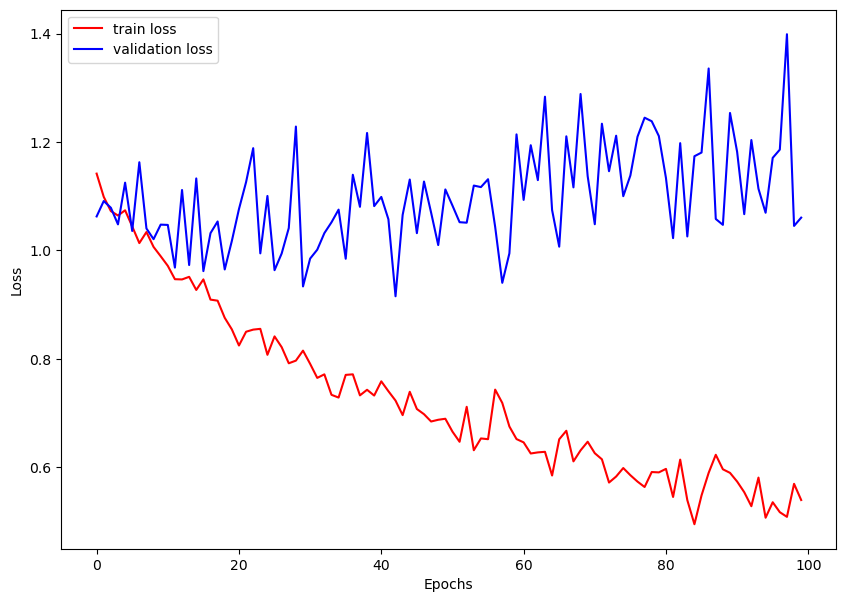

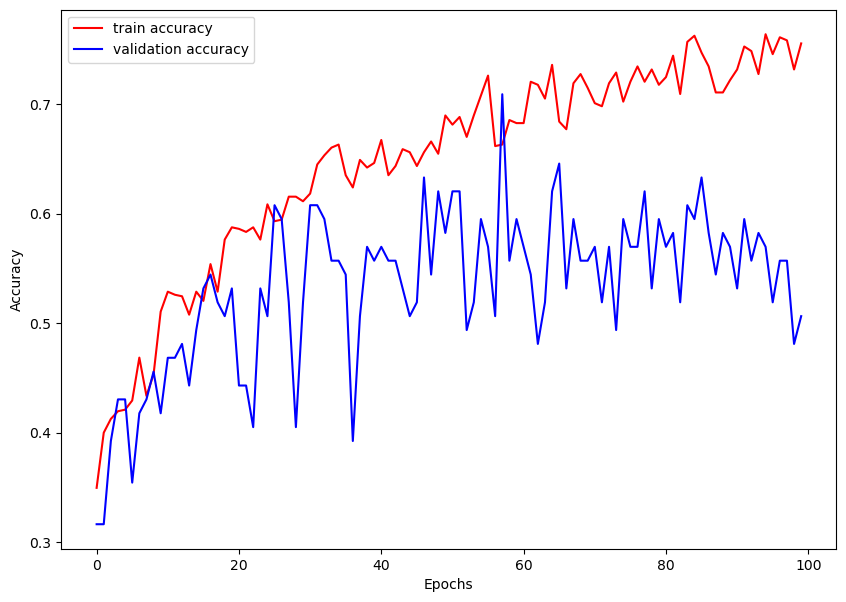

In [51]:
best_acc = 0
ind = 0
for i, m in enumerate(ensemble):
    if m['test_accuracy'] > best_acc:
        best_acc = m['test_accuracy']
        ind = i

loss_plot(ensemble[ind]['loss_history']['train_loss'], ensemble[ind]['loss_history']['valid_loss'])
accuracy_plot(ensemble[ind]['loss_history']['train_acc'], ensemble[ind]['loss_history']['valid_acc'])
print(
    f'Best model number is {ind}, loss is {ensemble[ind]["test_loss"]}, accuracy is {ensemble[ind]["test_accuracy"] * 100:.2f}% from epoch {ensemble[ind]["epoch"]}')

### Building the confusion matrix

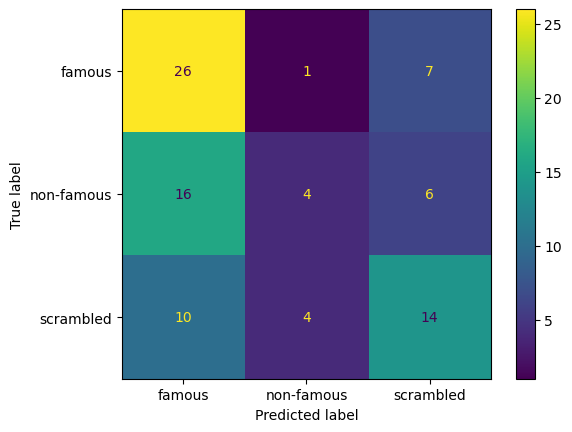

In [52]:
confusion_matrix = metrics.confusion_matrix(ensemble[ind]['test_targets'].to('cpu'), ensemble[ind]['test_predictions'].to('cpu'))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['famous', 'non-famous', 'scrambled'])
cm_display.plot()

## First experiment
Training within participant, without preprocessing

In [ ]:
parameters = {
    'model': {
        'sensors': 74,
        'samples': 250,
        'num_classes': 3,
        'filter_size': 16,
    },
    'spatial': {
        'spatial': False
    }
}

results = {}
for participant in participants:
    data = load_data(f"/home/daniil.kirillov@unitn.it/topography/data/FaceRecognition/sub-{participant}/eeg/sub-{participant}_task-FaceRecognition_eeg.set", simple_preprocess)

    ensemble = train_with_cross_validation(EEGNet, parameters, data, epochs=50, disable_logs=True)
    performance = [mdl['test_accuracy'] for mdl in ensemble]
    mean = np.mean(performance)
    std = np.std(performance)
    results[participant] = {
        'mean': mean,
        'std': std
    }

In [25]:
results

{'002': {'mean': 0.5181818187236786, 'std': 0.037757376041732627},
 '003': {'mean': 0.45909090638160704, 'std': 0.04663246800695639},
 '004': {'mean': 0.511363634467125, 'std': 0.04401118012494112},
 '006': {'mean': 0.5034090965986252, 'std': 0.0508324329943631},
 '007': {'mean': 0.5636363625526428, 'std': 0.02650432196248564},
 '008': {'mean': 0.5568181812763214, 'std': 0.04430360815650766},
 '009': {'mean': 0.5670454561710357, 'std': 0.036804844372343486},
 '010': {'mean': 0.5000000029802323, 'std': 0.04685347242699143},
 '011': {'mean': 0.6318181812763214, 'std': 0.03416658855329903},
 '012': {'mean': 0.5034090906381607, 'std': 0.04795669536797849},
 '013': {'mean': 0.5534090876579285, 'std': 0.03736200096455856},
 '014': {'mean': 0.5715909034013749, 'std': 0.04489714452012437},
 '015': {'mean': 0.5931818127632141, 'std': 0.05051388579961933},
 '016': {'mean': 0.6204545617103576, 'std': 0.041035154482961175},
 '017': {'mean': 0.546590906381607, 'std': 0.06356530006915155},
 '018': {

### Training with spatial component

In [ ]:
parameters = {
    'model': {
        'sensors': 74,
        'samples': 250,
        'num_classes': 3,
        'filter_size': 16,
    },
    'spatial': {
        'spatial': True,
        'lambda_regularization': SPATIAL_REGULARIZATION,
        'spatial_grid_width': 6
    }
}

results = {}
for participant in participants:
    data = load_data(f"/home/daniil.kirillov@unitn.it/topography/data/FaceRecognition/sub-{participant}/eeg/sub-{participant}_task-FaceRecognition_eeg.set", simple_preprocess)

    ensemble = train_with_cross_validation(EEGNet, parameters, data, epochs=50, disable_logs=True)
    performance = [mdl['test_accuracy'] for mdl in ensemble]
    mean = np.mean(performance)
    std = np.std(performance)
    results[participant] = {
        'mean': mean,
        'std': std
    }

In [27]:
results

{'002': {'mean': 0.509090906381607, 'std': 0.029105107314080544},
 '003': {'mean': 0.46590909361839294, 'std': 0.031736913070728144},
 '004': {'mean': 0.5443181782960892, 'std': 0.03573678200650194},
 '006': {'mean': 0.5170454472303391, 'std': 0.021710200263634356},
 '007': {'mean': 0.5715909123420715, 'std': 0.0397077343366814},
 '008': {'mean': 0.5659090936183929, 'std': 0.061573721973545936},
 '009': {'mean': 0.5272727191448212, 'std': 0.05061603862805658},
 '010': {'mean': 0.5147727251052856, 'std': 0.04686724488287218},
 '011': {'mean': 0.6102272689342498, 'std': 0.02785829497075089},
 '012': {'mean': 0.5034090906381607, 'std': 0.05750718755545671},
 '013': {'mean': 0.5500000059604645, 'std': 0.03416657665877397},
 '014': {'mean': 0.5920454502105713, 'std': 0.04016043753097676},
 '015': {'mean': 0.6102272689342498, 'std': 0.04659090841689032},
 '016': {'mean': 0.6602272748947143, 'std': 0.0407984664451937},
 '017': {'mean': 0.5363636314868927, 'std': 0.04815822798681704},
 '018': 

## Second experiment
Training between participants, without preprocessing

In [ ]:
parameters = {
    'model': {
        'sensors': 74,
        'samples': 250,
        'num_classes': 3,
        'filter_size': 16,
    },
    'spatial': {
        'spatial': False
    }
}

data = []
for participant in participants:
    d = load_data(f"/home/daniil.kirillov@unitn.it/topography/data/FaceRecognition/sub-{participant}/eeg/sub-{participant}_task-FaceRecognition_eeg.set", simple_preprocess)
    data.append(d)

ensemble = train_with_cross_validation_all_participants(EEGNet, parameters, data, epochs=50, disable_logs=True)
performance = [mdl['test_accuracy'] for mdl in ensemble]
mean = np.mean(performance)
std = np.std(performance)

mean is 0.44, std is 0.02
Best model number is 1, loss is 1.059254765510559, accuracy is 46.50% from epoch 38


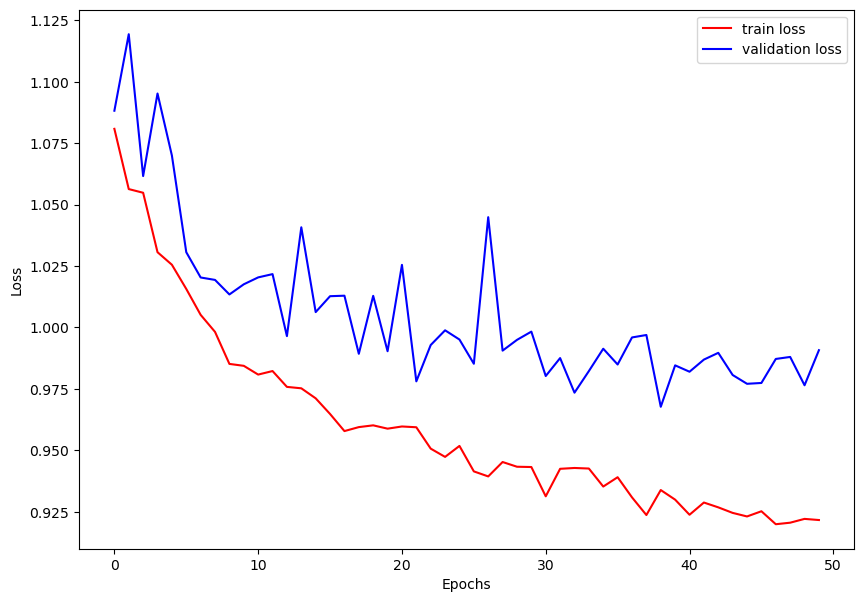

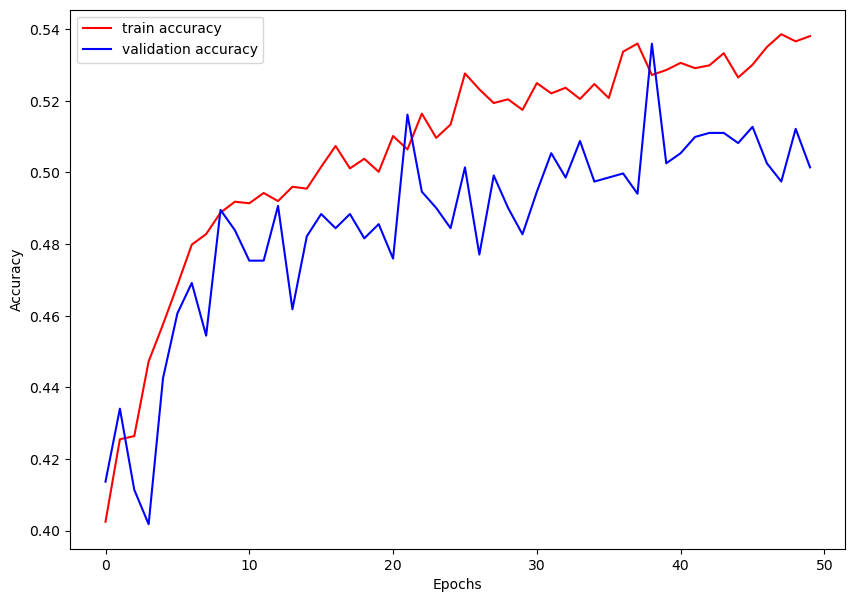

In [29]:
best_acc = 0
ind = 0
for i, m in enumerate(ensemble):
    if m['test_accuracy'] > best_acc:
        best_acc = m['test_accuracy']
        ind = i

loss_plot(ensemble[ind]['loss_history']['train_loss'], ensemble[ind]['loss_history']['valid_loss'])
accuracy_plot(ensemble[ind]['loss_history']['train_acc'], ensemble[ind]['loss_history']['valid_acc'])
print(f'mean is {mean:.2f}, std is {std:.2f}')
print(
    f'Best model number is {ind}, loss is {ensemble[ind]["test_loss"]}, accuracy is {ensemble[ind]["test_accuracy"] * 100:.2f}% from epoch {ensemble[ind]["epoch"]}')

### Trying with 9 classes

In [ ]:
parameters = {
    'model': {
        'sensors': 74,
        'samples': 250,
        'num_classes': 9,
        'filter_size': 16,
    },
    'spatial': {
        'spatial': False
    }
}

results = {}
for participant in participants:
    data = load_data(f"/home/daniil.kirillov@unitn.it/topography/data/FaceRecognition/sub-{participant}/eeg/sub-{participant}_task-FaceRecognition_eeg.set", multiclass_preprocess)

    ensemble = train_with_cross_validation(EEGNet, parameters, data, epochs=50, disable_logs=True)
    performance = [mdl['test_accuracy'] for mdl in ensemble]
    mean = np.mean(performance)
    std = np.std(performance)
    results[participant] = {
        'mean': mean,
        'std': std
    }

In [31]:
results

{'002': {'mean': 0.21590909138321876, 'std': 0.04979295700625645},
 '003': {'mean': 0.26136363446712496, 'std': 0.03173690400042596},
 '004': {'mean': 0.24204545468091965, 'std': 0.03666423898358876},
 '006': {'mean': 0.289772729575634, 'std': 0.045525513813153194},
 '007': {'mean': 0.2613636299967766, 'std': 0.017604465470813915},
 '008': {'mean': 0.202272729575634, 'std': 0.027742170544407842},
 '009': {'mean': 0.24204545319080353, 'std': 0.040671658905388285},
 '010': {'mean': 0.22954545617103578, 'std': 0.04027283326541315},
 '011': {'mean': 0.27613636702299116, 'std': 0.04283654335945808},
 '012': {'mean': 0.3409090906381607, 'std': 0.047943228881881315},
 '013': {'mean': 0.2693181797862053, 'std': 0.03631032840279693},
 '014': {'mean': 0.25568181425333025, 'std': 0.030597523866997024},
 '015': {'mean': 0.2920454487204552, 'std': 0.036664241477543096},
 '016': {'mean': 0.32386363446712496, 'std': 0.0452409799289065},
 '017': {'mean': 0.2784090951085091, 'std': 0.04437641998332401}

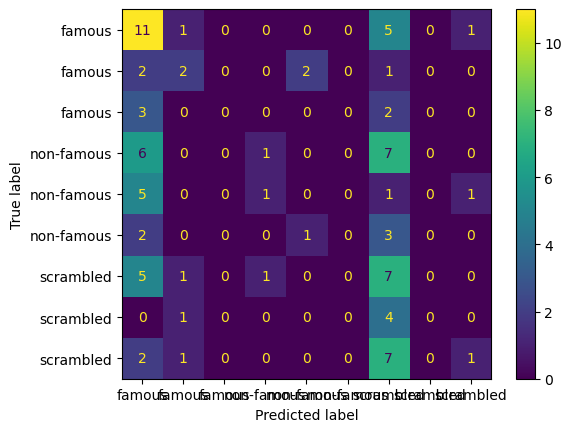

In [55]:
confusion_matrix = metrics.confusion_matrix(ensemble[0]['test_targets'].to('cpu'), ensemble[0]['test_predictions'].to('cpu'))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['famous', 'famous', 'famous',
                                                                                                   'non-famous', 'non-famous', 'non-famous',
                                                                                                   'scrambled', 'scrambled', 'scrambled'])
cm_display.plot()

### Testing with wave filtering

In [ ]:
parameters = {
    'model': {
        'sensors': 74,
        'samples': 301,
        'num_classes': 3,
        'filter_size': 16,
        'dropout': 0.25
    },
    'spatial': {
        'spatial': False
    }
}

subject_number = '002'

data = data = load_with_mne(f"/home/daniil.kirillov@unitn.it/topography/data/FaceRecognition/sub-{subject_number}/eeg/sub-{subject_number}_task-FaceRecognition_eeg.set")

ensemble = train_with_cross_validation(EEGNet, parameters, data, epochs=100, disable_logs=True)

Best model number is 5, loss is 1.2390785217285156, accuracy is 61.36% from epoch 86


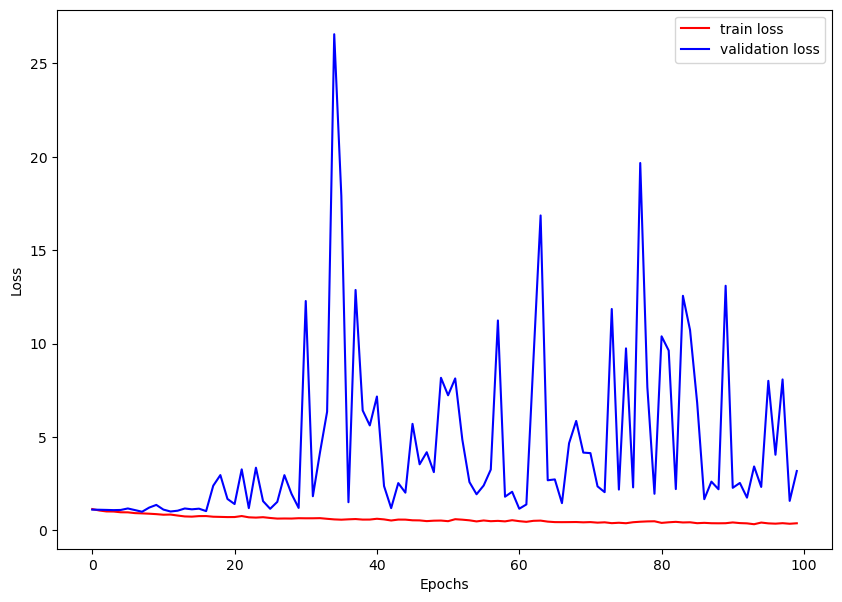

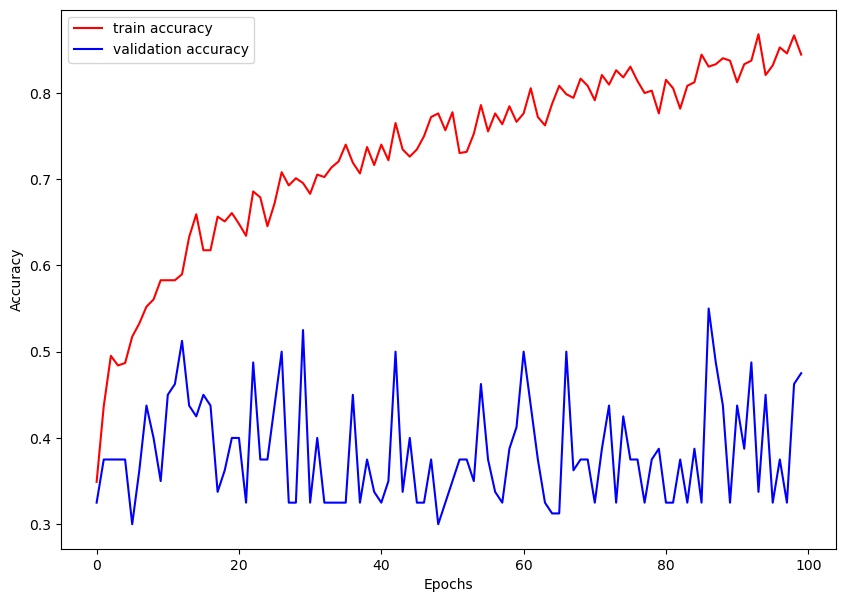

In [33]:
best_acc = 0
ind = 0
for i, m in enumerate(ensemble):
    if m['test_accuracy'] > best_acc:
        best_acc = m['test_accuracy']
        ind = i

loss_plot(ensemble[ind]['loss_history']['train_loss'], ensemble[ind]['loss_history']['valid_loss'])
accuracy_plot(ensemble[ind]['loss_history']['train_acc'], ensemble[ind]['loss_history']['valid_acc'])
print(
    f'Best model number is {ind}, loss is {ensemble[ind]["test_loss"]}, accuracy is {ensemble[ind]["test_accuracy"] * 100:.2f}% from epoch {ensemble[ind]["epoch"]}')

### Within participant with baseline correction applied

In [ ]:
parameters = {
    'model': {
        'sensors': 74,
        'samples': 301,
        'num_classes': 3,
        'filter_size': 16,
    },
    'spatial': {
        'spatial': False
    }
}

results = {}
for participant in participants:
    data = load_with_mne(f"/home/daniil.kirillov@unitn.it/topography/data/FaceRecognition/sub-{participant}/eeg/sub-{participant}_task-FaceRecognition_eeg.set")

    ensemble = train_with_cross_validation(EEGNet, parameters, data, epochs=50, disable_logs=True)
    performance = [mdl['test_accuracy'] for mdl in ensemble]
    mean = np.mean(performance)
    std = np.std(performance)
    results[participant] = {
        'mean': mean,
        'std': std
    }

In [35]:
results

{'002': {'mean': 0.49431818127632143, 'std': 0.09023185268707959},
 '003': {'mean': 0.3886363565921783, 'std': 0.049480775577713555},
 '004': {'mean': 0.4931818276643753, 'std': 0.03843531278828505},
 '006': {'mean': 0.5102272719144821, 'std': 0.04886363710081934},
 '007': {'mean': 0.5250000029802322, 'std': 0.026795064402059355},
 '008': {'mean': 0.5306818187236786, 'std': 0.07365354426776821},
 '009': {'mean': 0.4909090906381607, 'std': 0.0809614304394432},
 '010': {'mean': 0.5181818157434464, 'std': 0.09948212444634613},
 '011': {'mean': 0.5602272719144821, 'std': 0.08861450938963172},
 '012': {'mean': 0.5136363565921783, 'std': 0.032461035105814155},
 '013': {'mean': 0.5829545497894287, 'std': 0.05403406064877461},
 '014': {'mean': 0.5863636314868927, 'std': 0.03528221651023512},
 '015': {'mean': 0.5613636404275895, 'std': 0.05087052491648147},
 '016': {'mean': 0.5852272748947144, 'std': 0.042594704613024365},
 '017': {'mean': 0.5272727280855178, 'std': 0.05663606466055714},
 '018'

### Between participants with baseline correction

In [ ]:
parameters = {
    'model': {
        'sensors': 74,
        'samples': 301,
        'num_classes': 3,
        'filter_size': 16,
    },
    'spatial': {
        'spatial': False
    }
}

data = []
for participant in participants:
    d = load_with_mne(f"/home/daniil.kirillov@unitn.it/topography/data/FaceRecognition/sub-{participant}/eeg/sub-{participant}_task-FaceRecognition_eeg.set")
    data.append(d)

ensemble = train_with_cross_validation_all_participants(EEGNet, parameters, data, epochs=100, disable_logs=True)
performance = [mdl['test_accuracy'] for mdl in ensemble]
mean = np.mean(performance)
std = np.std(performance)

mean is 0.44, std is 0.02
Best model number is 6, loss is 1.0557764768600464, accuracy is 46.50% from epoch 40


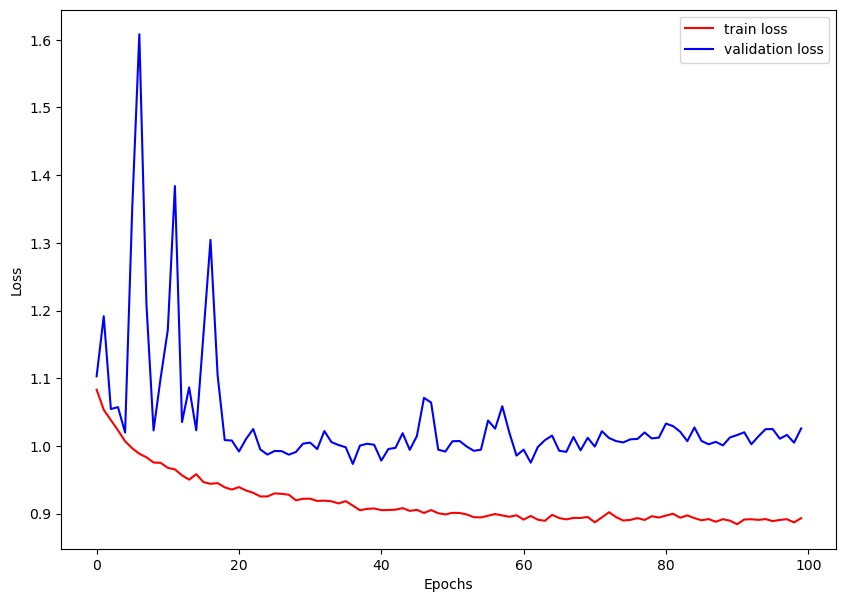

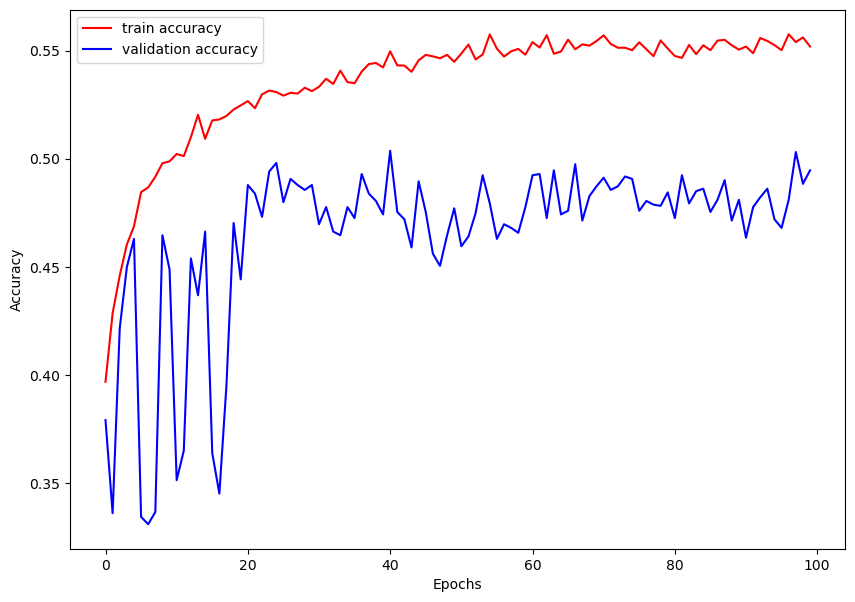

In [37]:
best_acc = 0
ind = 0
for i, m in enumerate(ensemble):
    if m['test_accuracy'] > best_acc:
        best_acc = m['test_accuracy']
        ind = i

loss_plot(ensemble[ind]['loss_history']['train_loss'], ensemble[ind]['loss_history']['valid_loss'])
accuracy_plot(ensemble[ind]['loss_history']['train_acc'], ensemble[ind]['loss_history']['valid_acc'])
print(f'mean is {mean:.2f}, std is {std:.2f}')
print(
    f'Best model number is {ind}, loss is {ensemble[ind]["test_loss"]}, accuracy is {ensemble[ind]["test_accuracy"] * 100:.2f}% from epoch {ensemble[ind]["epoch"]}')

### Within paricipant with baseline correction and spatial component

In [ ]:
parameters = {
    'model': {
        'sensors': 74,
        'samples': 301,
        'num_classes': 3,
        'filter_size': 16,
    },
    'spatial': {
        'spatial': True,
        'lambda_regularization': SPATIAL_REGULARIZATION,
        'spatial_grid_width': 6
    }
}

results = {}
for participant in participants:
    data = load_with_mne(f"/home/daniil.kirillov@unitn.it/topography/data/FaceRecognition/sub-{participant}/eeg/sub-{participant}_task-FaceRecognition_eeg.set")

    ensemble = train_with_cross_validation(EEGNet, parameters, data, epochs=50, disable_logs=True)
    performance = [mdl['test_accuracy'] for mdl in ensemble]
    mean = np.mean(performance)
    std = np.std(performance)
    results[participant] = {
        'mean': mean,
        'std': std
    }

In [39]:
results

{'002': {'mean': 0.5443181902170181, 'std': 0.05193816164301225},
 '003': {'mean': 0.38863636255264283, 'std': 0.04652156866501037},
 '004': {'mean': 0.4909090906381607, 'std': 0.054687315142251974},
 '006': {'mean': 0.4772727280855179, 'std': 0.052813404427988875},
 '007': {'mean': 0.5613636374473572, 'std': 0.041035153162485606},
 '008': {'mean': 0.530681824684143, 'std': 0.06035578226121525},
 '009': {'mean': 0.5488636374473572, 'std': 0.0693181856733862},
 '010': {'mean': 0.49431818127632143, 'std': 0.0890796078645563},
 '011': {'mean': 0.5545454561710358, 'std': 0.06424224313410518},
 '012': {'mean': 0.5011363625526428, 'std': 0.055309516539779995},
 '013': {'mean': 0.6056818246841431, 'std': 0.05032178825456289},
 '014': {'mean': 0.5897727251052857, 'std': 0.06044130174794076},
 '015': {'mean': 0.5840909004211425, 'std': 0.03975648328446125},
 '016': {'mean': 0.6238636374473572, 'std': 0.0730196583269495},
 '017': {'mean': 0.5181818187236786, 'std': 0.05478167793771948},
 '018': 

### Between participants with baseline correction and spatial component

In [ ]:
parameters = {
    'model': {
        'sensors': 74,
        'samples': 301,
        'num_classes': 3,
        'filter_size': 16,
    },
    'spatial': {
        'spatial': True,
        'lambda_regularization': SPATIAL_REGULARIZATION,
        'spatial_grid_width': 6
    }
}

data = []
for participant in participants:
    d = load_with_mne(f"/home/daniil.kirillov@unitn.it/topography/data/FaceRecognition/sub-{participant}/eeg/sub-{participant}_task-FaceRecognition_eeg.set")
    data.append(d)

ensemble = train_with_cross_validation_all_participants(EEGNet, parameters, data, epochs=100, disable_logs=True)
performance = [mdl['test_accuracy'] for mdl in ensemble]
mean = np.mean(performance)
std = np.std(performance)

mean is 0.44, std is 0.01
Best model number is 3, loss is 1.1054972410202026, accuracy is 46.27% from epoch 41


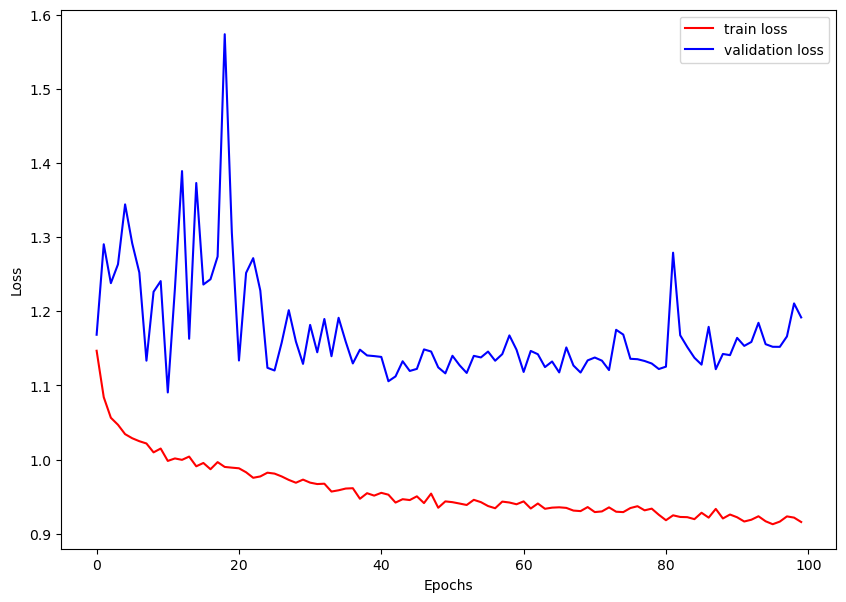

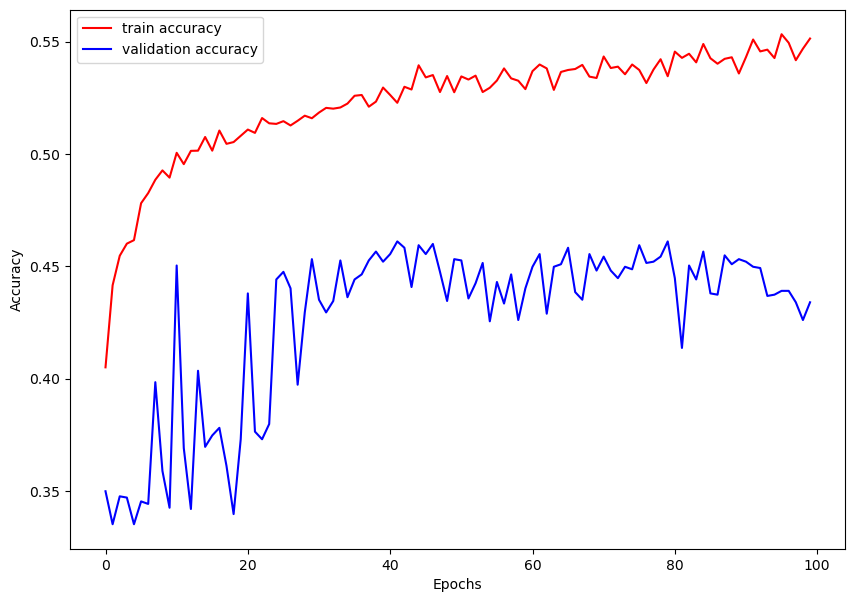

In [41]:
best_acc = 0
ind = 0
for i, m in enumerate(ensemble):
    if m['test_accuracy'] > best_acc:
        best_acc = m['test_accuracy']
        ind = i

loss_plot(ensemble[ind]['loss_history']['train_loss'], ensemble[ind]['loss_history']['valid_loss'])
accuracy_plot(ensemble[ind]['loss_history']['train_acc'], ensemble[ind]['loss_history']['valid_acc'])
print(f'mean is {mean:.2f}, std is {std:.2f}')
print(
    f'Best model number is {ind}, loss is {ensemble[ind]["test_loss"]}, accuracy is {ensemble[ind]["test_accuracy"] * 100:.2f}% from epoch {ensemble[ind]["epoch"]}')